<a href="https://colab.research.google.com/github/meriemdouider1/2/blob/main/VGG(adma).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model

In [284]:
! pip install -q kaggle

In [285]:
from google.colab import files

In [286]:
files.upload()

Saving kaggle.json to kaggle (7).json


{'kaggle.json': b'{"username":"meryemdouider","key":"71abdf1b37f401d9b4f539d2b43177eb"}'}

In [287]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "sshikamaru/glaucoma-detection"

kaggle.json
glaucoma-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [288]:
!unzip glaucoma-detection.zip

Archive:  glaucoma-detection.zip
replace Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/002.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/003.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/004.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/005.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/006.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/007.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/008.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/009.jpg  
  inflating: Fundus_Train_Val_Dat

In [289]:
DATAGlua_Train = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
DATAGlua_Test = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

In [290]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATAGlua_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['Glaucoma_Negative', 'Glaucoma_Positive']


In [291]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
def creation_train_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
creation_train_data()

In [292]:
x_test_data = []
y_test_data = []
IMG_SIZE=224
def creation_test_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
creation_test_data ()

In [293]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.05, random_state=1)

In [294]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [295]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

# **VGG16 Model**

In [296]:
IMG_SHAPE = (224, 224,3)


In [297]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [298]:
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


In [299]:
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model.layers))

input_9
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [300]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [301]:
base_model.trainable = False

In [302]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [303]:
x = layers.GlobalMaxPooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='softmax')(x)

model = Model(base_model.input, x)
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [304]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [305]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')


In [306]:
train_datagen.fit(X_Train)

In [307]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen.fit(X_Val)

In [308]:
train_model = model.fit(X_Train, Y_Train, batch_size=64, epochs=25,
                    validation_data=(X_Val, Y_Val))

Epoch 1/25
8/8 [==============================] - 3s 267ms/step - loss: 11.1273 - accuracy: 0.6320 - val_loss: 4.5314 - val_accuracy: 0.8077
Epoch 2/25
8/8 [==============================] - 2s 242ms/step - loss: 11.4785 - accuracy: 0.6430 - val_loss: 3.3048 - val_accuracy: 0.8077
Epoch 3/25
8/8 [==============================] - 2s 241ms/step - loss: 9.1570 - accuracy: 0.6834 - val_loss: 3.6306 - val_accuracy: 0.8462
Epoch 4/25
8/8 [==============================] - 2s 241ms/step - loss: 7.7737 - accuracy: 0.6757 - val_loss: 4.3740 - val_accuracy: 0.8462
Epoch 5/25
8/8 [==============================] - 2s 242ms/step - loss: 7.4652 - accuracy: 0.6808 - val_loss: 3.5462 - val_accuracy: 0.8462
Epoch 6/25
8/8 [==============================] - 2s 242ms/step - loss: 7.8414 - accuracy: 0.7061 - val_loss: 3.4603 - val_accuracy: 0.8462
Epoch 7/25
8/8 [==============================] - 2s 242ms/step - loss: 7.1074 - accuracy: 0.6828 - val_loss: 3.1373 - val_accuracy: 0.8462
Epoch 8/25
8/8 [==

In [309]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [310]:
opt=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [311]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [312]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [313]:
train_model  = model.fit(X_Train, Y_Train, batch_size=64, epochs=30,
                    validation_data=(X_Val, Y_Val))

Epoch 1/30
8/8 [==============================] - 3s 308ms/step - loss: 6.1024 - acc: 0.6755 - val_loss: 0.9455 - val_acc: 0.7692
Epoch 2/30
8/8 [==============================] - 2s 279ms/step - loss: 2.2068 - acc: 0.7210 - val_loss: 1.4611 - val_acc: 0.6538
Epoch 3/30
8/8 [==============================] - 2s 280ms/step - loss: 1.3045 - acc: 0.7545 - val_loss: 1.0071 - val_acc: 0.8077
Epoch 4/30
8/8 [==============================] - 2s 280ms/step - loss: 1.3105 - acc: 0.7455 - val_loss: 1.0958 - val_acc: 0.7692
Epoch 5/30
8/8 [==============================] - 2s 281ms/step - loss: 0.8410 - acc: 0.8262 - val_loss: 1.0538 - val_acc: 0.6923
Epoch 6/30
8/8 [==============================] - 2s 282ms/step - loss: 0.5459 - acc: 0.8680 - val_loss: 1.0711 - val_acc: 0.8077
Epoch 7/30
8/8 [==============================] - 2s 282ms/step - loss: 0.4533 - acc: 0.8625 - val_loss: 1.9106 - val_acc: 0.7692
Epoch 8/30
8/8 [==============================] - 2s 285ms/step - loss: 0.3688 - acc: 0.90

In [314]:
loss_val, acc_val = model.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 114ms/step - loss: 1.7037 - acc: 0.7692
Validation: accuracy = 0.769231  ;  loss_v = 1.703663


test:

In [315]:
y_test_data = to_categorical(y_test_data)
loss_test, acc_test = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

5/5 [==============================] - 1s 96ms/step - loss: 2.2455 - acc: 0.7000
Test: accuracy = 0.700000  ;  loss = 2.245503


In [316]:
model.save("VGG16.h5")

Text(0.5, 1.0, 'Training and validation loss')

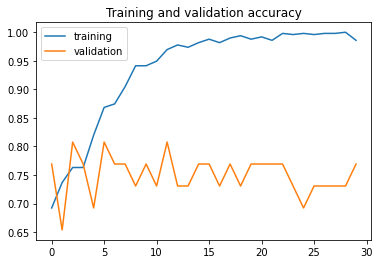

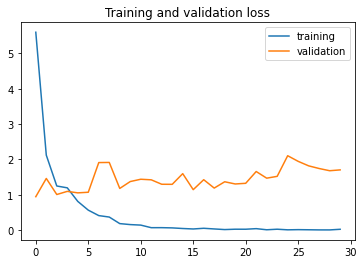

In [317]:
acc = train_model.history['acc']
val_acc = train_model .history['val_acc']

loss = train_model.history['loss']
val_loss = train_model .history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()


plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')